# Detectando Niveles Jugables en Zelda

## Resumen
En este archivo se estará realizando un algoritmo de ML con redes neuronales que tomará imagenes del dataset guardado en el folder `dataset`  con diferentes niveles del videojuego Zelda. La máquina deberá aprender a reconocer si el nivel de la imagen es jugable o no jugable. La manera de reconocer si un nivel es jugable es porque se debe cumplir que:

1. El personaje de Link se encuentre en el nivel
2. Haya al menos una puerta a la que Link pueda avanzar
3. Haya al menos una llave para que Link pueda acceder a la puerta

## Estado de arte

Tras una investigación sobre el estado de arte hubo varias investigaciones que llamaron mi atención para implementar mi modelo. Pero la que mayormente destacó fue una que habla sobre el aprendizaje profundo por refuerzo sensible a objetos [1]. El O-DRL mejora el aprendizaje produnfo por refuerzo al incorporar información sobre objetos en el proceso de aprendizaje. Esto se logra al agregar más canales a la representación del estado del agente que codifican la presencia y ubicación de los objetos detectados en la imagen. Así el agente puede diferenciar entre objetos importantes y evitar objetos dañinos. 

Debido a que en mi dataset y proyecto, las cosas a identificar esenciales son los objetos en los niveles, como lo serían las llaves, puertas y el personaje de Link. Este paper va muy bien para aplicarlo a mi modelo y que sea más fácil en identificar los objetos. Ya que esta técnica ayuda mucha en computer vision para la detección de objetos. En mi caso creo que puedo aplicar la arquitectura que se plantea en el que puedo aplicar hacer el gradiente en mi número de capas. Ir disminuyendo el tamaño de la capa conforme va avanzando. Asimismo, creo que sería buena práctica realizar el mapa de saliencia tal y como lo mencionan en el artículo. Creo que esta implementación puede ayudar a entender cómo está realizando y analizando las imágenes en mi algoritmo. 


### Fuentes
[1] Li, Y., Sycara, K., & Iyer, R. (2018). Object-sensitive deep reinforcement learning. arXiv preprint arXiv:1809.06064.
[2] B. van Oostendorp, “Object Detection for Reinforcement Learning Agents”, Syst. Theor. Control Comput. J., vol. 3, no. 2, pp. 9–14, Dec. 2023, doi: 10.52846/stccj.2023.3.2.51.
[3] Jung M, Yang H, Min K. "Improving Deep Object Detection Algorithms for Game Scenes". Electronics. 2021; 10(20):2527. https://doi.org/10.3390/electronics10202527

In [34]:
#### PACKAGE IMPORTS ####

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Cargar el dataset y procesar los datos

Found 1640 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

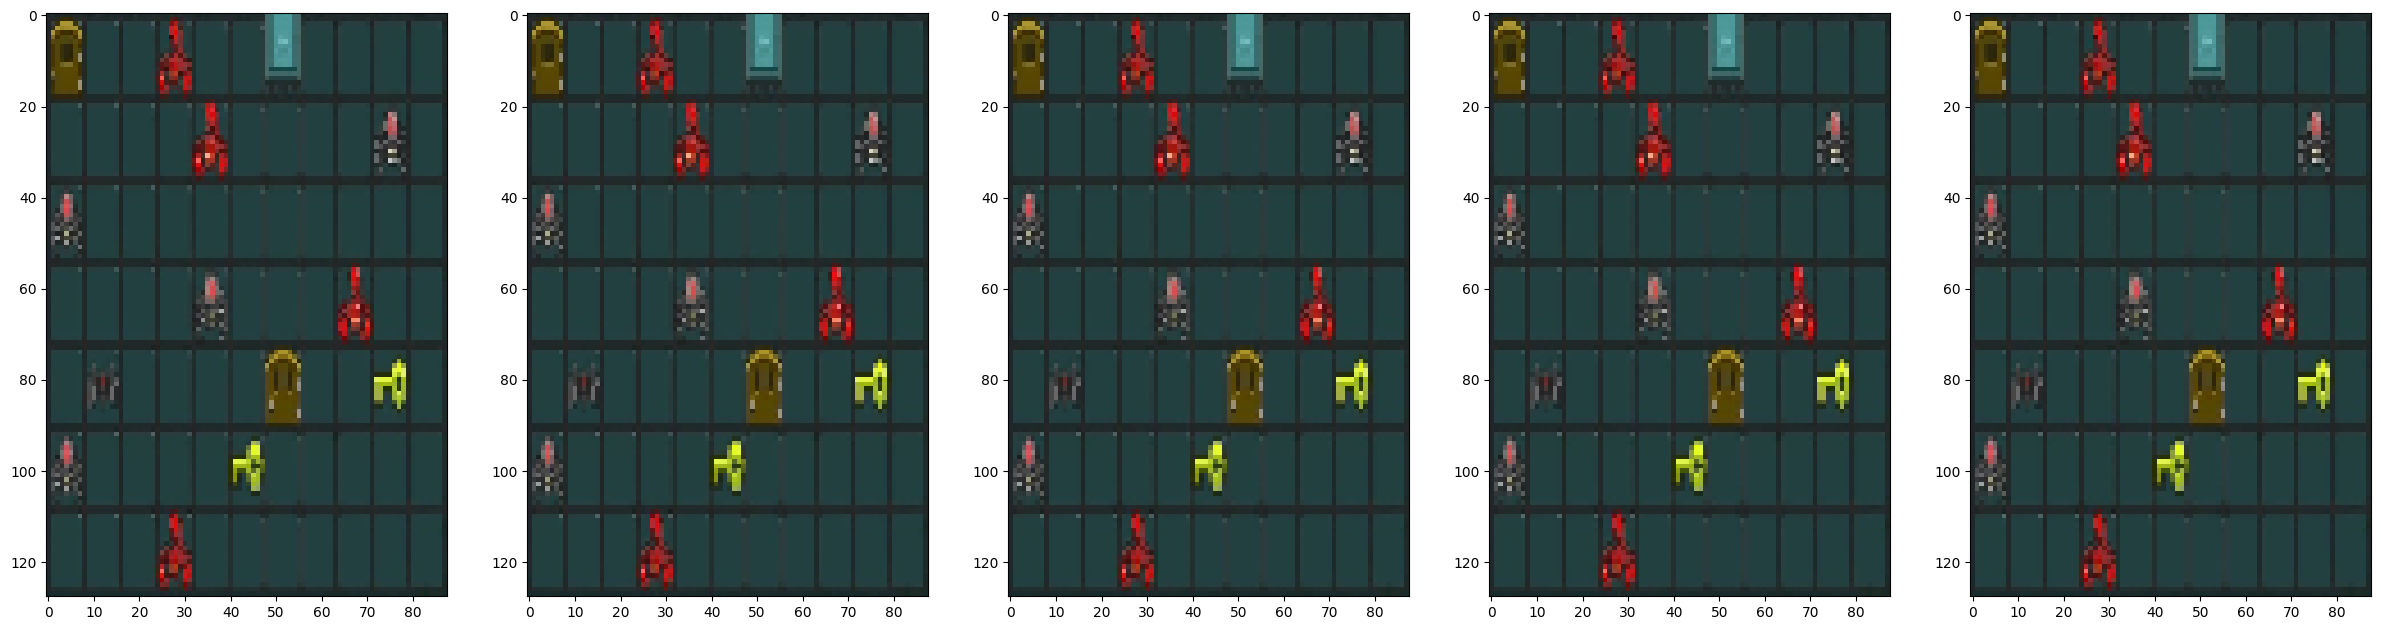

In [35]:
# Rutas a los directorios de entrenamiento y prueba
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Crear generadores de imágenes para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar las imágenes de entrenamiento y prueba
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 88),
    batch_size=32,
    class_mode='binary'
)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])


test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 88),
    batch_size=32,
    class_mode='binary'
)

S

In [36]:
# Definir la arquitectura del modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 88, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary()

# Compilar el modelo
model.compile(optimizer= 'adam',loss= 'sparse_categorical_crossentropy',metrics = ['accuracy'] )
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Users/paulina/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 86, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,457,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,477,186 (9.45 MB)

 Trainable params: 2,477,186 (9.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/paulina/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4915 - loss: 0.7131
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5445 - loss: 0.6932
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.5691 - loss: 0.6882
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.6793 - loss: 0.6651
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7265 - loss: 0.6099
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7734 - loss: 0.5446
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7861 - loss: 0.4944
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8050 - loss: 0.4593
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7903 - loss: 0.4283
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8152 - loss: 0.4051
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7542 - loss: 0.5101
Precisión en el conjunto de prueba: 0.7671568393707275


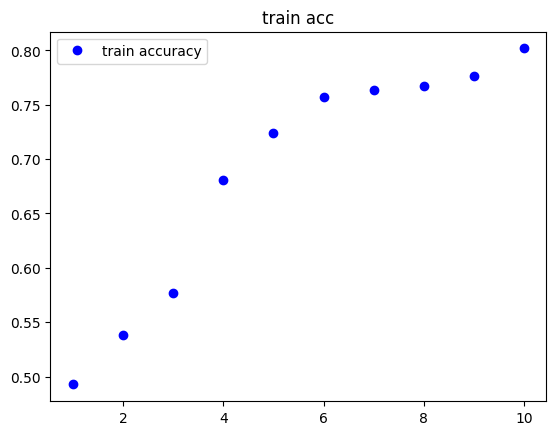

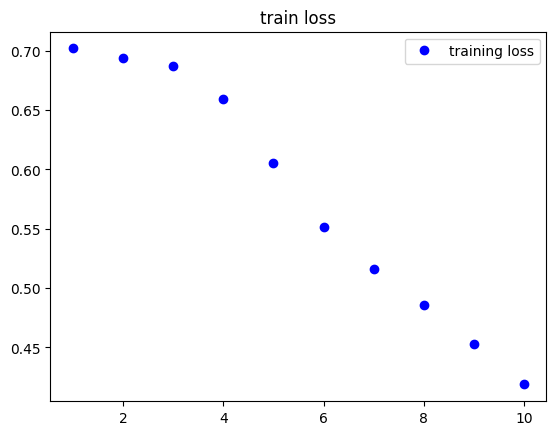

In [37]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    # steps_per_epoch=len(train_generator),
    epochs=10,
    # validation_data=test_generator,
    # validation_steps=len(test_generator)
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('Precisión en el conjunto de prueba:', test_acc)


acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()


## Evaluación del modelo
Aquí se realizan los cálculos para realizar la matriz de confusión. Además, basándome en el paper previamente mencionado, se sacan los valores de precisión, sensibilidad y F1 para posteriormente interpretarlos. 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


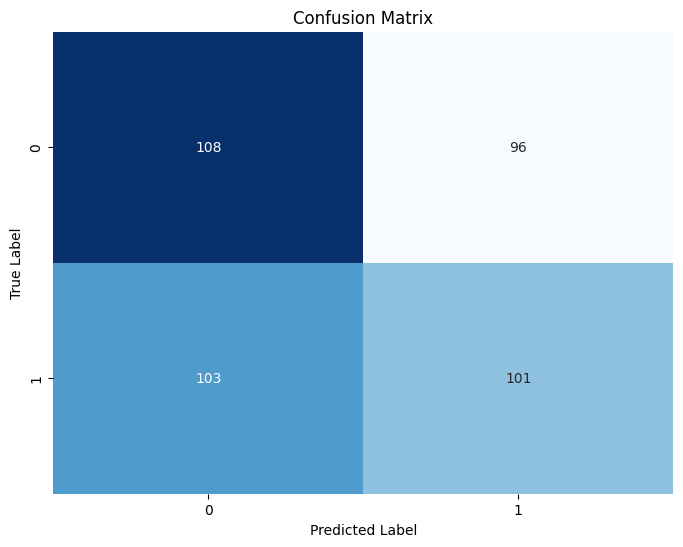

Precisión: 0.5126903553299492
Sensibilidad (Recall): 0.4950980392156863
Puntuación F1: 0.5037406483790524


In [39]:
# Get the predictions for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the test generator
true_labels = test_generator.labels
print(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# # Evaluación del modelo y obtención de la matriz de confusión
# test_loss, test_acc = model.evaluate(test_generator)
# print('Precisión en el conjunto de prueba:', test_acc)

# Cálculo de métricas adicionales
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print('Precisión:', precision)
print('Sensibilidad (Recall):', recall)
print('Puntuación F1:', f1_score)
